<a href="https://colab.research.google.com/github/Buyan-Kirill/practice-VTM-sem-8/blob/main/Tensors_task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\Large{ALS}$

In [1]:
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
from itertools import accumulate

# Развёртка тензора
def unfold(tensor, ax=0):
    if ax < 0 or ax >= len(tensor.shape):
        raise ValueError("Недопустимый номер направления")
    tensor_1 = np.moveaxis(tensor, ax, 0)
    return tensor_1.reshape((tensor.shape[ax], -1))

errors = []
iters = []

In [2]:
class ALS:
    def __init__(self, T) -> None:
      self.T = T.copy()
      self.dimensions = self.T.shape
      self.d = len(self.dimensions)
      self.BT_B = None
      self.BT_T = None

    # Размеры тензора
    @property
    def shape(self):
        return self.dimensions

    # Размерность тензора
    @property
    def len(self):
        return self.d

    # Вычисление Адамарова произведения U.T @ U кроме тех, что в except (для B_k.T @ B_k)
    def get_UT_U_adamar_with_except(self, excepts: list[int]):
        p = self.cores[0].shape[1]  # Число столбцов p
        # Проверка согласованности размеров
        for i, mat in enumerate(self.cores):
            if mat.shape[1] != p:
                raise ValueError(f"Матрица {i} имеет {mat.shape[1]} столбцов, ожидалось {p}.")

        # Вычисляем U_i^T U_i для всех матриц, кроме тех, что в excepts
        UT_U = []
        for i, U_i in enumerate(self.cores):
            if not (i in excepts):
                UT_U.append(U_i.T @ U_i) # U_i^T U_i


        # Если после исключения не осталось матриц, возвращаем единичную матрицу
        if not UT_U:
            return np.eye(p)

        # Вычисляем поэлементное произведение
        result = UT_U[0]
        for U_i in UT_U[1:]:
            result *= U_i  # Адамарово произведение
        return result

    # Нахождение B_k.T @ B_k
    def calculate_BT_B(self, d: int) -> None:
        self.BT_B = np.array(self.get_UT_U_adamar_with_except([d]), dtype=np.float64)

    # Нахождение B_k
    def get_Bk(self, k: int):
        p = self.cores[0].shape[1]  # Число столбцов должно быть одинаковым
        # Проверка согласованности размеров
        for i, mat in enumerate(self.cores):
            if mat.shape[1] != p:
                raise ValueError(f"Матрица {i} имеет {mat.shape[0]} столбцов, ожидалось {p}.")

        needed_matrices = [mat for i, mat in enumerate(self.cores) if i != k]

        if not needed_matrices:
            return np.eye(p)

        # Вычисляем произведение Хатри-Рао для оставшихся матриц
        B_k = needed_matrices[0]
        for mat in needed_matrices[1:]:
            m1, p1 = B_k.shape
            m2, p2 = mat.shape
            # Вычисляем Khatri-Rao по столбцам
            kr_product = np.zeros((m1 * m2, p1))
            for j in range(p1):
                kr_product[:, j] = np.kron(B_k[:, j], mat[:, j])
            B_k = kr_product

        return B_k

    # Нахождение B_k.T @ T_k
    def calculate_BT_T(self, d: int) -> None:
        B_i = self.get_Bk(d) # Находим B_i
        T_i = unfold(self.T, d) # Находим развёртку тензора в i-ом направлении
        self.BT_T = B_i.T @ T_i.T # B_i.T @ транспонированную развёртку тензора в i-ом направлении

    # Нахождение матрицы D для балансировки (предобуславливания)
    def calculate_D(self):
        self.D = np.diag(1.0 / np.sqrt(np.diag(self.BT_B)))

    # Шаг оптимизации
    def optimizer(self) -> None:
        # Пройдём по каждой размерности и найдём новые ядра, решив системы через Холецкого
        for d in range(self.d):
            self.calculate_BT_B(d)
            self.calculate_BT_T(d)
            self.calculate_D()

            # Предобусловаливание
            A = self.D @ self.BT_B @ self.D
            b = self.D @ self.BT_T

            L = linalg.cholesky(A, lower=True)

            # Решение системы
            y = linalg.solve_triangular(L, b, lower=True)
            x_ = linalg.solve_triangular(L.T, y, lower=False)

            # Возвращение к исходной переменной
            x = self.D @ x_

            self.cores[d] = x.T


    # Получить относительную ошибку аппроксимирования
    # cores - ядра разложения
    def get_approx_error(self, cores):
        T_approx = np.ones((1, self.rank))
        for j in range(self.d):
            T_approx = linalg.khatri_rao(T_approx, cores[j])

        relative_error = np.linalg.norm(np.sum(T_approx, axis=1) - self.T.reshape(-1,)) / np.linalg.norm(self.T.reshape(-1,))
        return relative_error


    # Получить аппрокисимацию тензора в каноническом формате
    # tol - точность
    # max_iter_num - максимальное число итераций
    def CP(self, rank, seed=42, tol = 10**-9, max_iter_num = 100):
        self.rank = rank # rank - ранг аппроксимации
        np.random.seed(seed)
        self.cores = np.array([np.random.rand(self.dimensions[i], rank) for i in range(self.len)], dtype=object) # Ядра аппроксимации

        rel_error = self.get_approx_error(self.cores)

        for it in range(max_iter_num):
            self.optimizer()
            rel_error = self.get_approx_error(self.cores)

            global errors, lambdas, iters
            errors.append(rel_error)
            iters.append(it)


            if rel_error < tol:
                print(f'Converged with error={rel_error} in {it + 1} iterations')
                break

        if rel_error >= tol:
            print(f'Didn\'t onverged in {it + 1} iterations. Relative error = {rel_error}')
        return self.cores

In [3]:
def plot_errors():
    global errors, lambdas, iters
    print()

    plt.plot(iters, errors, label='Errors')
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.title('Errors over Iterations')
    plt.legend()
    plt.show()

    errors, lambdas, iters = [], [], []

In [4]:
def f(i, j, k, l):
    return (i + j + k + l)

sizes = (9, 27, 13, 11)
T = np.fromfunction(f, sizes)

ALS_appr = ALS(T)

Didn't onverged in 100 iterations. Relative error = 1.879097898963927e-09



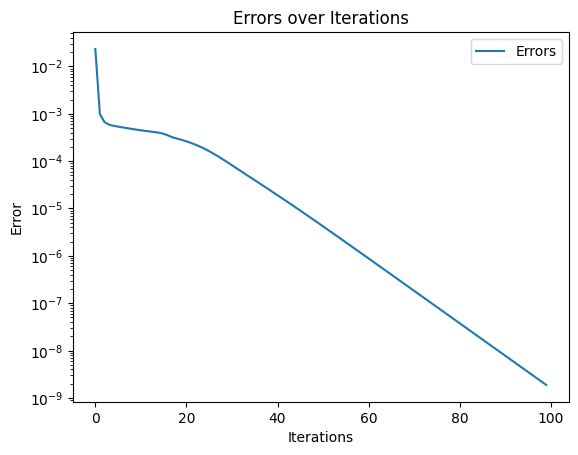

In [5]:
errors, iters = [], []
rank = 6
new_cores = ALS_appr.CP(rank)
plot_errors()

Converged with error=8.734705586646047e-10 in 12 iterations



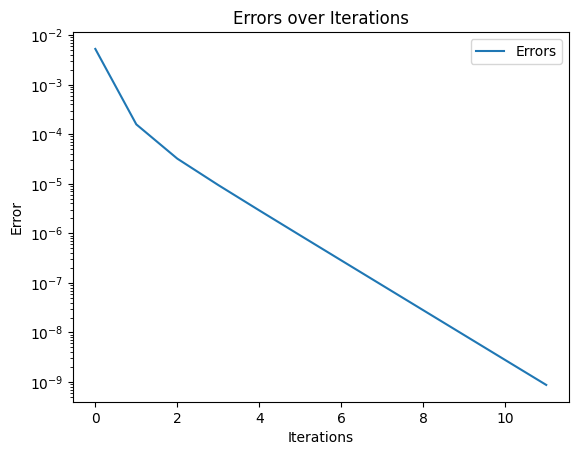

In [6]:
errors, iters = [], []
rank = 7
new_cores = ALS_appr.CP(rank)
plot_errors()

In [7]:
def f(i, j, k, l, s):
    return np.sin(i + j + k + l + s)

sizes = (9, 27, 13, 11, 8)
T = np.fromfunction(f, sizes)

ALS_appr = ALS(T)

Converged with error=2.5945147807795046e-10 in 12 iterations



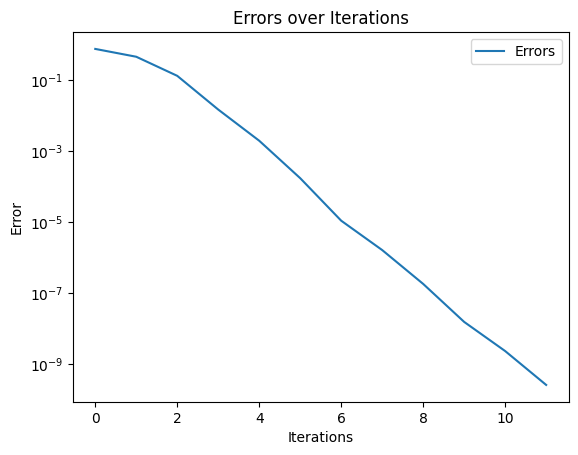

In [8]:
rank = 5
errors, iters = [], []
new_cores = ALS_appr.CP(rank)
plot_errors()